# 0. Configuración inicial

In [ ]:
import os
import sys
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import (
    f1_score,
    precision_recall_curve,
    auc,
    classification_report,
    roc_auc_score,
    make_scorer
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances
import mlflow
from mlflow.models.signature import infer_signature

import shap

import joblib


pd.set_option("display.max_columns", None)


In [2]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
from proyecto_final import utils

## 0.1 Cargar datos

In [3]:
df = pd.read_parquet("../data/entrega3/X_t2.parquet")
print(df.shape)
df.head()

(177184, 77)


,borrow_block_number,borrow_timestamp,wallet_address,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count
0,12331303,1.619645e+09,0x597568694fe6ee1b701ec8578bd57102c9a29abd,1.598065e+09,1.619644e+09,21579599.0,434,610,-176,16.315639,0.026747,64,26,1598289727,1619644457,21354730,12188.884750,132962.068126,133616.442475,90.327492,90.772040,4838.061843,19.206706,189.677291,0.522687,17442.857992,8723.344724,6699.099071,3584.052638,1338.299716,0.0,0.436011,0.713303,15891.732259,1765.748029,9,7506.587978,1072.369711,7,8385.144281,12,30449.724789,21456246.0,11404.699764,0.0,0,999999999.0,0.000000,23.017795,25.160789,107.15407,100.0,100.0,115.81891,164.227291,34.506367,0.939154,31.986284,97.581566,71.738192,1,5.56673,107.15407,123.534791,129.738387,154.458464,113.452663,118.941164,-0.361351,4.799905,30.851881,818.14583,4.748082,0.135601,1.135601,2,2
1,12331310,1.619645e+09,0xaf8609004fe2d76f47207ebba1abdaede4d87503,1.612412e+09,1.619592e+09,7233196.0,380,471,-91,19.860949,0.042257,162,23,1613097912,1619591811,6493899,2281.885311,5992.726631,5945.565745,4.700178,4.663189,142.915042,0.086935,1.754191,0.671626,1336.580064,796.986132,337.247096,106.397562,426.377913,1583.0,0.769202,0.916198,2516.567494,33.112730,76,1934.674124,38.693482,50,581.893371,93,2951.356429,7232795.0,2197.271938,0.0,1,927688.0,285.277937,23.017795,25.160789,107.15407,100.0,100.0,115.81891,164.227291,34.506367,0.939154,31.986284,97.581566,71.738192,1,5.56673,107.15407,123.534791,129.738387,154.458464,113.452663,118.941164,-0.361351,4.799905,30.851881,818.14583,4.748082,0.135601,1.135601,1,2
2,12331317,1.619645e+09,0x292e6e377f7cf99157943da9e4b87318ffbe2917,1.616073e+09,1.619642e+09,3572088.0,190,210,-20,4.661248,0.022196,106,3,1616074575,1619641902,3567327,29974.009356,67796.801388,67802.455623,133.196073,133.207182,860.314536,0.544124,0.949481,0.703633,137914.242758,91423.289050,30654.914628,19525.169261,30479.959803,0.0,0.677773,0.802720,11382.915742,271.021803,42,3232.981819,538.830303,6,8149.933923,56,39103.013851,3570302.0,24932.928971,0.0,0,999999999.0,0.000000,23.017795,25.160789,107.15407,100.0,100.0,115.81891,164.227291,34.506367,0.939154,31.986284,97.581566,71.738192,1,5.56673,107.15407,123.534791,129.738387,154.458464,113.452663,118.941164,-0.361351,4.799905,30.851881,818.14583,4.748082,0.135601,1.135601,1,1
3,12331322,1.619645e+09,0x597568694fe6ee1b701ec8578bd57102c9a29abd,1.598065e+09,1.619645e+09,21579964.0,436,612,-176,16.407644,0.026810,65,26,1598289727,1619644760,21355033,15923.646750,136696.830126,137351.204475,92.487706,92.930450,4838.061843,19.206706,189.677291,0.641498,79415.5

In [4]:
Y = pd.read_parquet("../data/entrega3/y_t2.parquet")
predict_data_3 = pd.read_parquet("../data/entrega3/X_t3.parquet")

# 1. Introducción

El presente proyecto aborda el problema de predicción de morosidad en clientes bancarios, un desafío crucial en la gestión del riesgo crediticio. El objetivo principal es construir un modelo de machine learning capaz de predecir si un cliente será moroso o no, permitiendo al banco tomar decisiones informadas para mitigar riesgos y optimizar recursos. Esta problemática tiene una alta relevancia práctica, ya que una predicción precisa puede reducir pérdidas financieras y mejorar la asignación de estrategias de cobranza.

Los datos utilizados en este proyecto son transaccionales, derivados de detalles de préstamos otorgados a diversas billeteras. Este conjunto de datos presenta varios desafíos, como la alta dimensionalidad, desbalance en las clases y la presencia de outliers. Las características incluyen variables categóricas, numéricas y de tiempo, siendo risk_factor la variable más importante en el proceso predictivo, dado su fuerte relación lógica con el riesgo de morosidad. Para abordar estos desafíos, se aplicaron técnicas de reducción de dimensionalidad, eliminación de variables de identificación para evitar sesgos, y tratamiento de outliers mediante reemplazo por la mediana.

Dado el desbalance de las clases, se seleccionó la métrica AUC-PR (Área Bajo la Curva de Precisión-Recall) como principal para evaluar el desempeño de los modelos, ya que esta es especialmente adecuada para casos donde las clases positivas (clientes morosos) son mucho menos frecuentes que las negativas. Además, se complementó el análisis con métricas como F1-score, precisión y recall, centradas en la clase positiva, para asegurar que el modelo no solo identificara correctamente a los clientes morosos, sino que también lo hiciera de manera consistente y con un bajo índice de falsos positivos.

A lo largo del proyecto, se probaron y compararon varios modelos, incluyendo Random Forest y LightGBM, siendo XGBoost el modelo que demostró el mejor rendimiento en todas las iteraciones. El pipeline implementado incluyó transformaciones clave como la eliminación de columnas con alta correlación, la estandarización de variables numéricas con MinMaxScaler, la codificación de variables categóricas mediante OneHotEncoder y la optimización de hiperparámetros utilizando Optuna. Además, se integraron herramientas de MLOps como Docker, FastAPI y Gradio para garantizar la reproducibilidad y escalabilidad del sistema.

En términos de resultados, el modelo final cumplió con los objetivos planteados, logrando un AUC-PR de 0.85 en su mejor iteración y demostrando una mejora significativa respecto al modelo baseline. A pesar de una ligera disminución en el AUC-PR en la última etapa (0.73), las decisiones tomadas a lo largo del proyecto, tanto técnicas como estratégicas, garantizaron un balance entre rendimiento, robustez y escalabilidad del modelo.

# 2. Preprocesamiento

## 2.1 EDA

Empezando con el análisis exploratorio de los datos, se analiza el estado de las etiquetas de los datos, donde se observa que: si bien no están en la misma proporción, la diferencia de estos es suficiente para poder realizar el resto del trabajo sin la necesidad de trabajar sobre las etiquetas, ya que de esto se pueden encargar los modelos a utilizar.

In [5]:
Y["target"].value_counts()

target
0    108875
1     68309
Name: count, dtype: int64

Siguiendo con el EDA, se define un dataframe copia de los datos originales para poder desarollar cambios y no afectar en el futuro preprocesamiento. Se borran las variables `borrow_block_number` y `wallet_address` porque son identificadores y afectan en las conclusiones que se pueden obtener de las variables. En particular `wallet_address`porque es un string y no permite visualizar todas las variables de manera ordenada, y `borrow_block_number`puede entregar sesgo por personas que sean de algún bloque, por lo que se eliminan en un inicio.

In [6]:
df_eda = df.copy()
df_eda = df_eda.drop(["borrow_block_number", "wallet_address"], axis=1)

Se transforman a fechas las variables timestamp para visualizar su comportamiento en el tiempo. 

In [7]:
df_eda["borrow_timestamp"] = pd.to_datetime(df_eda["borrow_timestamp"], unit="s")
df_eda["first_tx_timestamp"] = pd.to_datetime(df_eda["first_tx_timestamp"], unit="s")
df_eda["last_tx_timestamp"] = pd.to_datetime(df_eda["last_tx_timestamp"], unit="s")
df_eda["risky_first_tx_timestamp"] = pd.to_datetime(df_eda["risky_first_tx_timestamp"], unit="s")
df_eda["risky_last_tx_timestamp"] = pd.to_datetime(df_eda["risky_last_tx_timestamp"], unit="s")

df_eda.dtypes

borrow_timestamp                 datetime64[ns]
first_tx_timestamp               datetime64[ns]
last_tx_timestamp                datetime64[ns]
wallet_age                              float64
incoming_tx_count                         int64
                                      ...      
market_ppo                              float64
market_rocp                             float64
market_rocr                             float64
unique_borrow_protocol_count              int64
unique_lending_protocol_count             int64
Length: 75, dtype: object

In [8]:
numerical_cols = df_eda.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_eda.select_dtypes(include=['object', 'category']).columns.tolist()
date_cols = df_eda.select_dtypes(include=['datetime']).columns.tolist()

print(f"Columnas numéricas: {len(numerical_cols)}")
print(f"Columnas categóricas: {len(categorical_cols)}")
print(f"Columnas de fecha: {len(date_cols)}")

Columnas numéricas: 70
Columnas categóricas: 0
Columnas de fecha: 5


Para el desarrollo del proyecto, es importante manejar las variables que tienen alta correlación entre sí, en parte para disminuir la dimensionalidad del df de entrada y para que el modelo aprenda de manera más eficiente. 

Se fija en 0.9 el límite para determinar si una variable esta altamente correlacionada con otra, el siguiente código entrega los pares de variables con alta correlación.

In [9]:
corr_matrix = df_eda[numerical_cols].corr()

threshold = 0.9
high_corr = corr_matrix.unstack().reset_index()
high_corr.columns = ['Var1', 'Var2', 'Correlation']
high_corr = high_corr[(high_corr['Var1'] != high_corr['Var2']) & (high_corr['Correlation'].abs() > threshold)]

print("Pares de variables con alta correlación:")
print(high_corr)

Pares de variables con alta correlación:
                           Var1                       Var2  Correlation
143           outgoing_tx_count      net_incoming_tx_count    -0.998582
212       net_incoming_tx_count          outgoing_tx_count    -0.998582
313          total_gas_paid_eth              deposit_count     0.903390
853         outgoing_tx_avg_eth        incoming_tx_avg_eth     0.974924
922         incoming_tx_avg_eth        outgoing_tx_avg_eth     0.974924
1849      borrow_amount_sum_eth       repay_amount_sum_eth     0.986091
1856      borrow_amount_sum_eth    withdraw_amount_sum_eth     0.906744
1991               borrow_count                repay_count     0.909327
2056       repay_amount_sum_eth      borrow_amount_sum_eth     0.986091
2066       repay_amount_sum_eth    withdraw_amount_sum_eth     0.918397
2198                repay_count               borrow_count     0.909327
2314              deposit_count         total_gas_paid_eth     0.903390
2546    withdraw_amount

Utilizando el `describe` se pueden observar las principales estadísticas de cada variable, donde lo principal es determinar la dispersión de los datos. 

In [10]:
df_eda.describe()

,borrow_timestamp,first_tx_timestamp,last_tx_timestamp,wallet_age,incoming_tx_count,outgoing_tx_count,net_incoming_tx_count,total_gas_paid_eth,avg_gas_paid_per_tx_eth,risky_tx_count,risky_unique_contract_count,risky_first_tx_timestamp,risky_last_tx_timestamp,risky_first_last_tx_timestamp_diff,risky_sum_outgoing_amount_eth,outgoing_tx_sum_eth,incoming_tx_sum_eth,outgoing_tx_avg_eth,incoming_tx_avg_eth,max_eth_ever,min_eth_ever,total_balance_eth,risk_factor,total_collateral_eth,total_collateral_avg_eth,total_available_borrows_eth,total_available_borrows_avg_eth,avg_weighted_risk_factor,risk_factor_above_threshold_daily_count,avg_risk_factor,max_risk_factor,borrow_amount_sum_eth,borrow_amount_avg_eth,borrow_count,repay_amount_sum_eth,repay_amount_avg_eth,repay_count,borrow_repay_diff_eth,deposit_count,deposit_amount_sum_eth,time_since_first_deposit,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,liquidation_count,time_since_last_liquidated,liquidation_amount_sum_eth,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastk,market_fastd,market_ht_trendmode,market_linearreg_slope,market_macd_macdext,market_macd_macdfix,market_macd,market_macdsignal_macdext,market_macdsignal_macdfix,market_macdsignal,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,unique_borrow_protocol_count,unique_lending_protocol_count
count,177184,177184,177184,1.771840e+05,177184.000000,1.771840e+05,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184,177184,1.771840e+05,1.771840e+05,1.771840e+05,1.771840e+05,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,1.771840e+05,1.771840e+05,1.771840e+05,1.771840e+05,1.771840e+05,1.771840e+05,177184.000000,177184.000000,177184.000000,1.771840e+05,177184.000000,177184.000000,1.771840e+05,177184.000000,177184.000000,1.771840e+05,177184.000000,1.771840e+05,1.771840e+05,1.771840e+05,1.771840e+05,177184.000000,1.771840e+05,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000,177184.000000
mean,2021-10-28 03:54:39.579510272,2020-09-12 13:45:15.499802112,2021-10-26 16:08:03.148478208,3.547496e+07,722.478638,2.457742e+03,-1735.263015,29.156530,0.019152,147.320661,22.902440,2018-06-07 18:26:24.622923264,2018-12-04 05:59:30.932222976,1.550719e+07,1.648272e+04,8.601808e+04,7.974551e+04,25.497783,25.408207,2479.624474,8.871973,258.803033,3.959321e-01,3.018313e+04,2.761621e+04,6.571890e+03,6.487043e+03,9.026414e+03,2803.953585,12.960941,73.994374,1.934626e+04,187.572364,49.123708,1.625560e+04,177.759153,34.124041,3.365118e+03,63.636350,3.740425e+04,1.388625e+07,3.410742e+04,1.941011e+03,0.819211,8.438555e+08,145.779602,30.415844,30.160620,11.241572,16.104953,51.192425,189.891933,2.977616,2.701659,0.922171,31.382849,54.966002,55.103663,0.942275,1.098434,11.241572,9.918144,10.415385,12.782280,10.462620,10.995174,-0.603719,7.681982,21.015366,1923.005434,0.243623,0.019589,1.019589,1.004391,1.310395
min,2021-04-28 21:16:48,2015-07-30 15:26:13,2020-02-26 21:15:15,0.000000e+00,0.000000,0.000000e+00,-995735.000000,0.000000,0.000000,0.000000,0.000000,2001-09-09 01:46:39,2001-09-09 01:46:39,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.235150e-15,0.000000e+00,0.000000e+00,-8.454855e+03,-6.646408e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.900000e+01,0.000000,15.651815,18.359003,-644.180069,-84.444444,0.000000,115.

En base a lo observado con las estadísticas generales, se realiza un histograma para cada variable númerica con el fin de entender sus distribuciones. Se observa que gran parte de las variables tienen outliers que generan ruido que no permite visualizar bien el comportamiento de todas variable. 

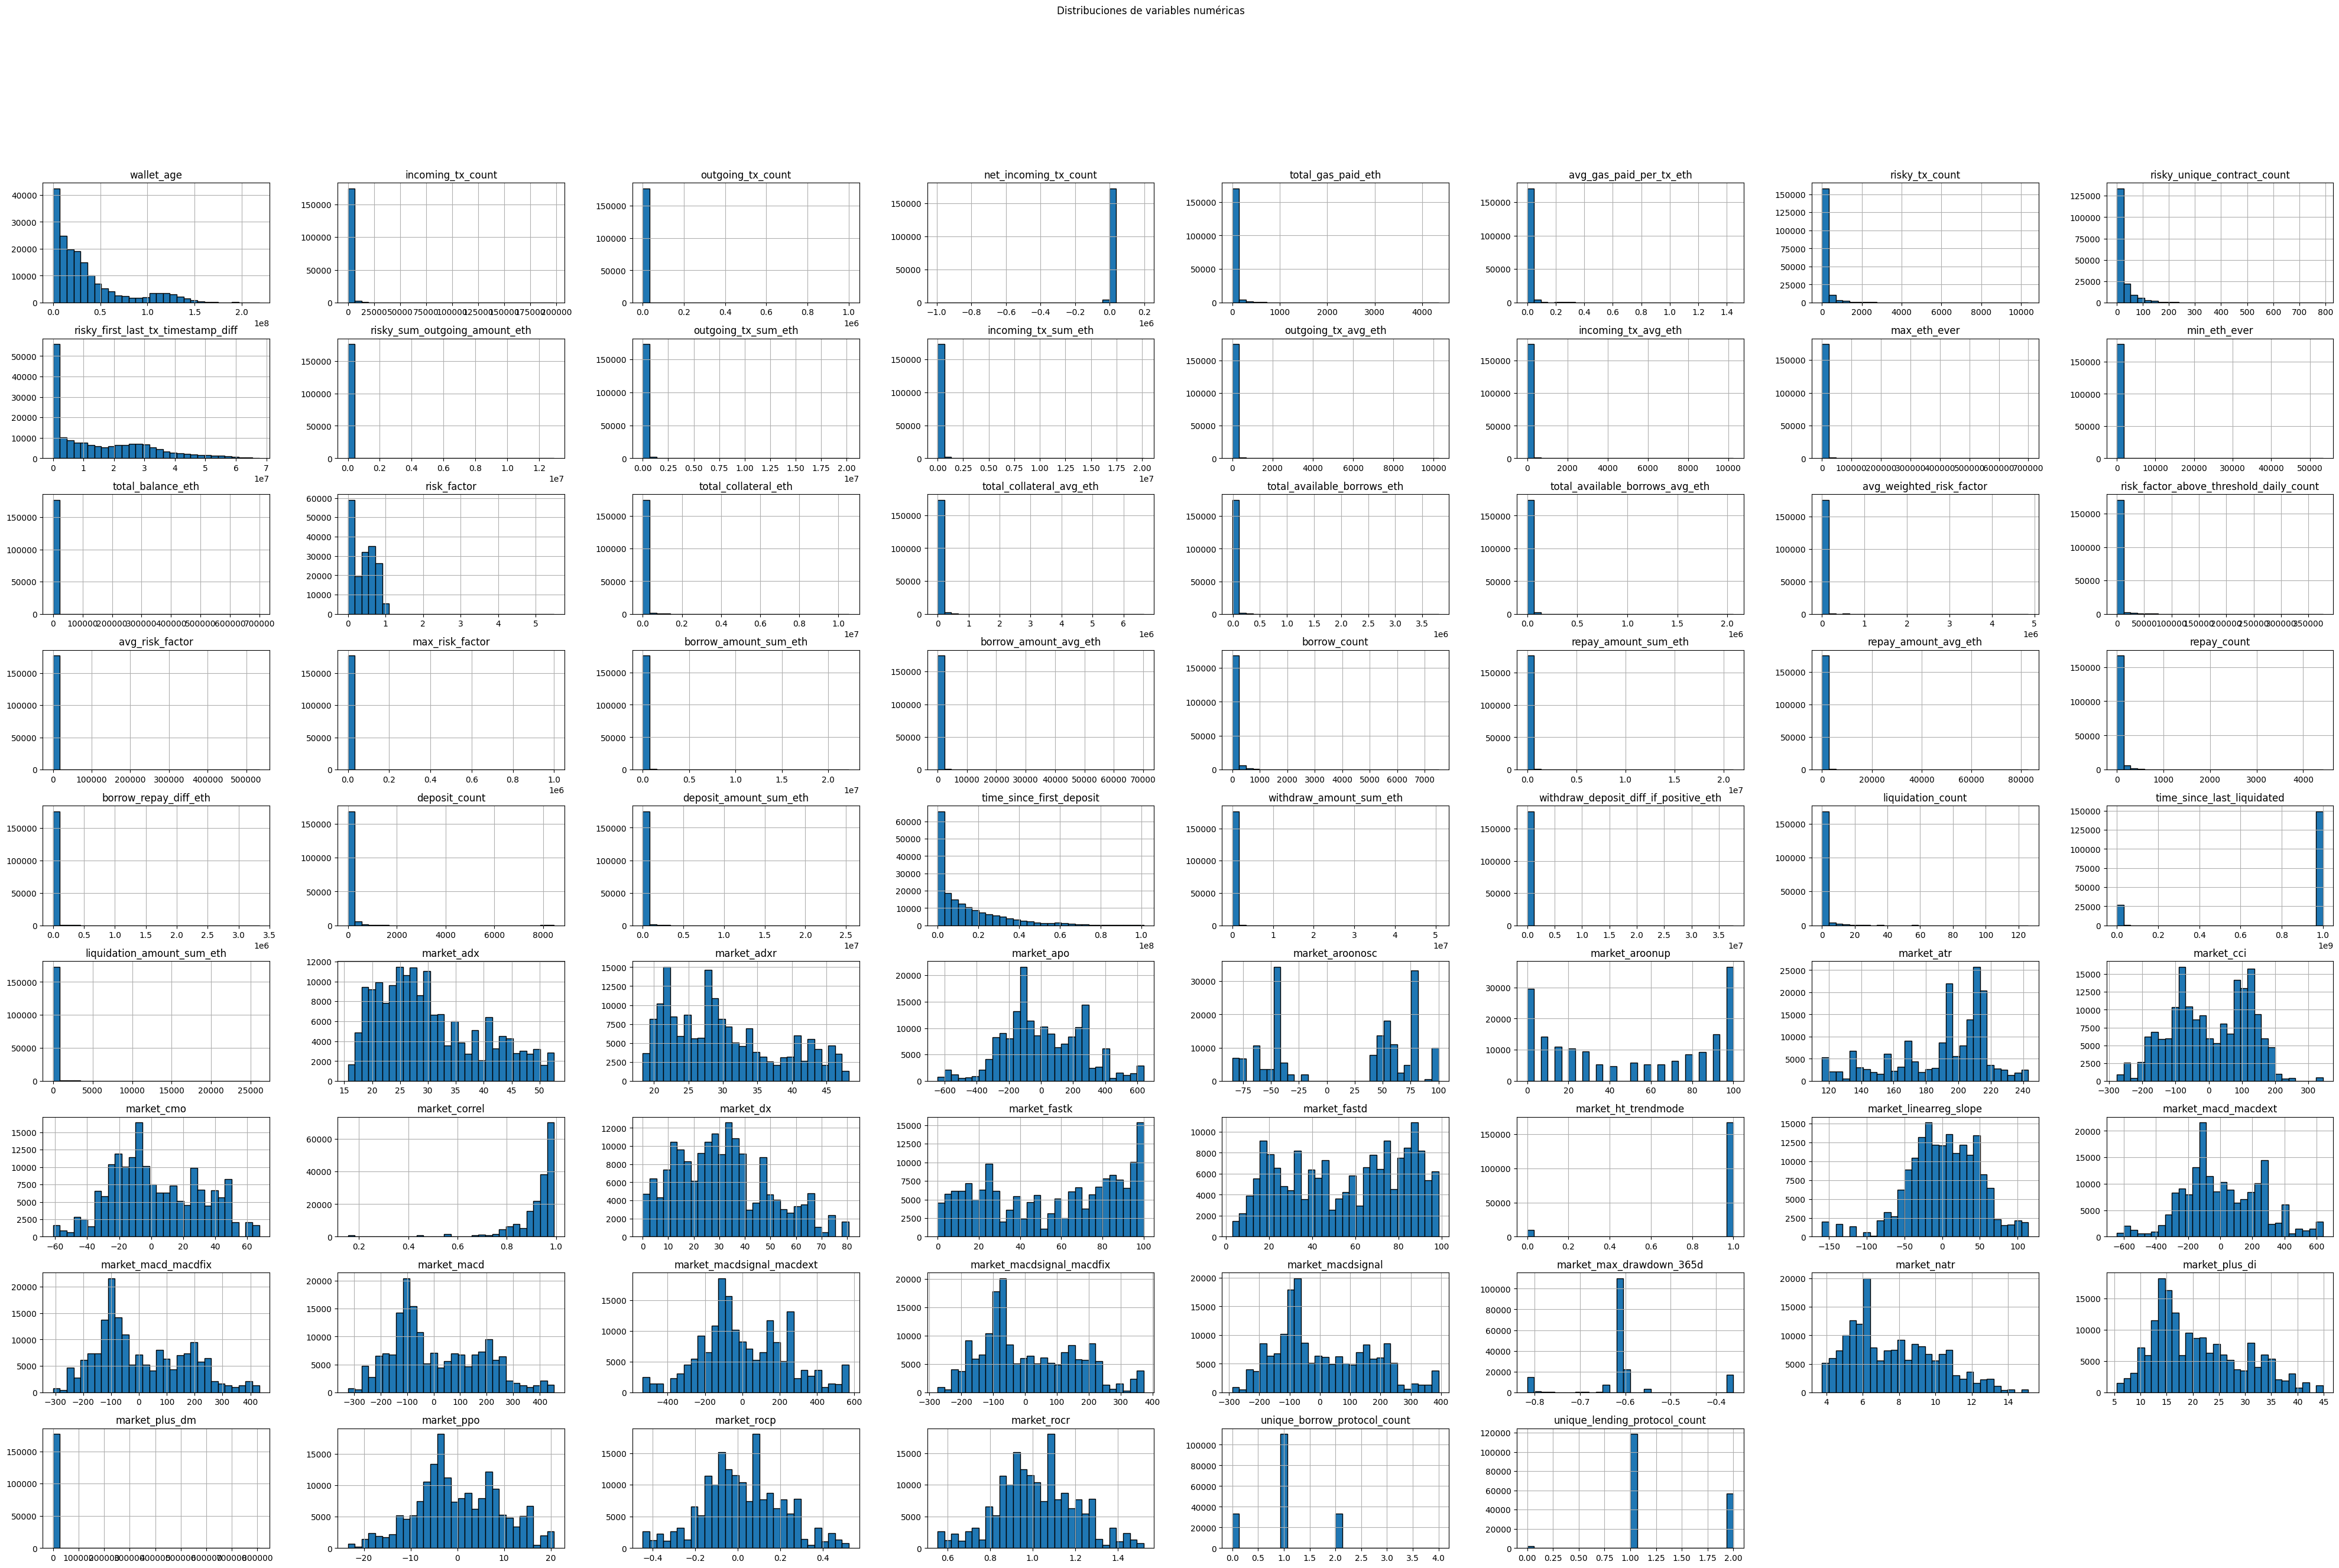

In [11]:
df_eda[numerical_cols].hist(figsize=(50, 30), bins=30, edgecolor="black")
plt.suptitle("Distribuciones de variables numéricas")
plt.show()

A continuación el comportamiento en el tiempo de las variables fechas. Donde se observa que las variables asociadas al riesgo tienen fechas que no coinciden con el resto de la información. 

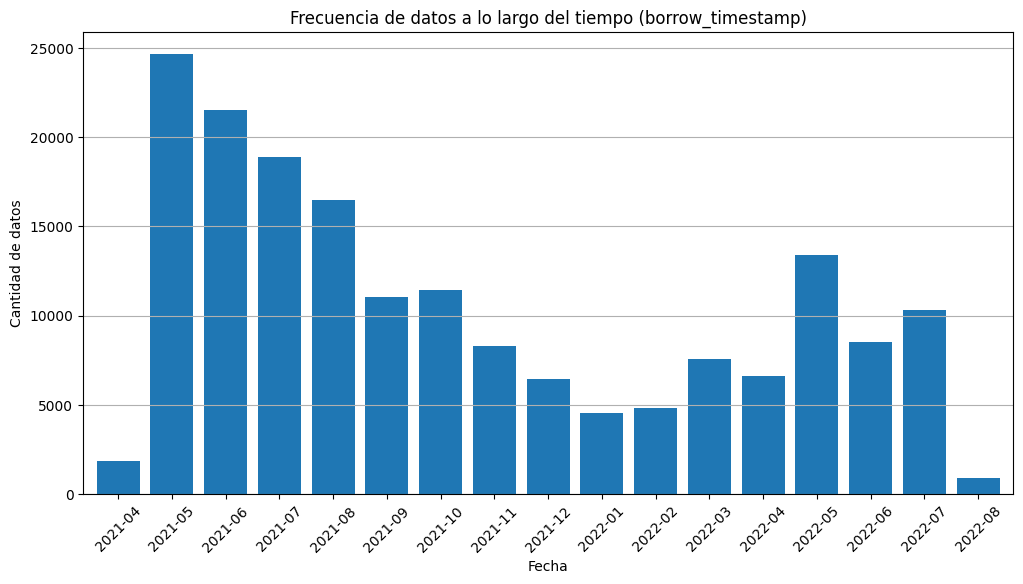

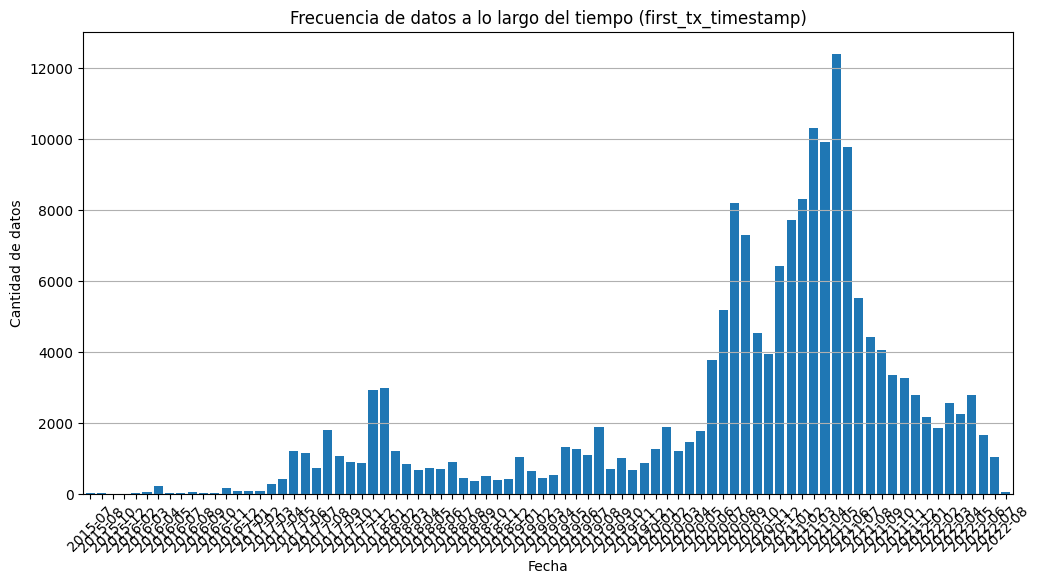

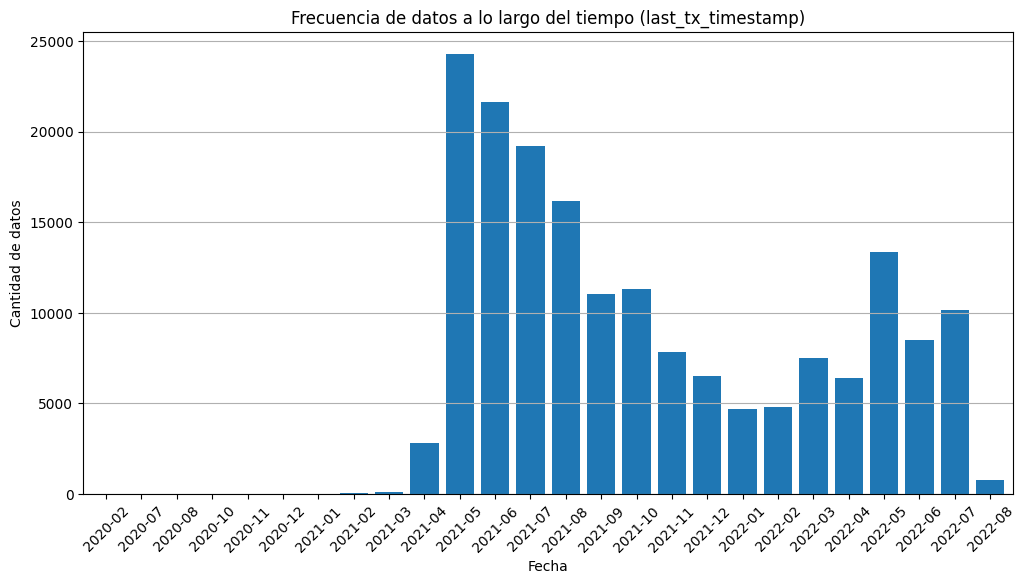

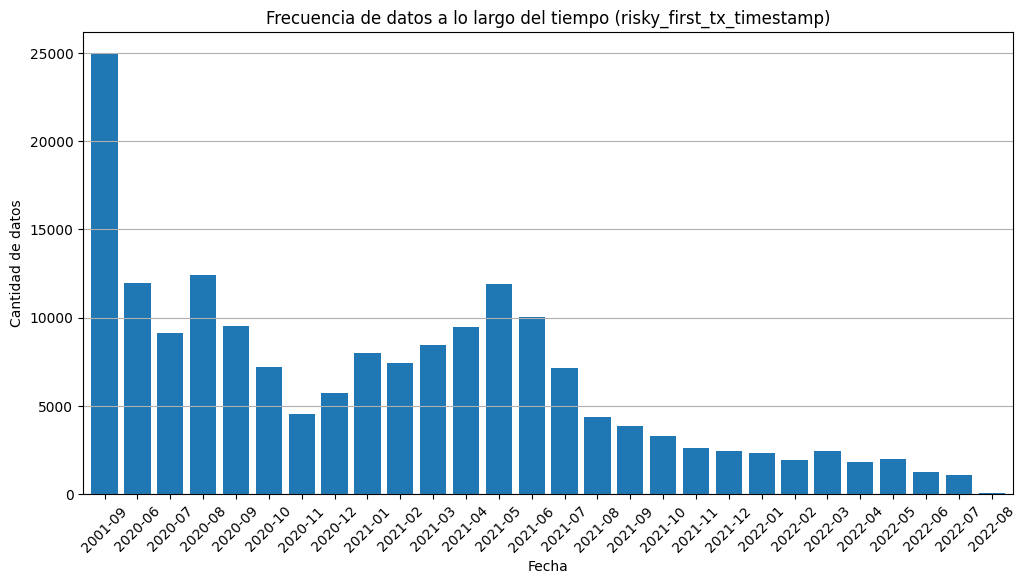

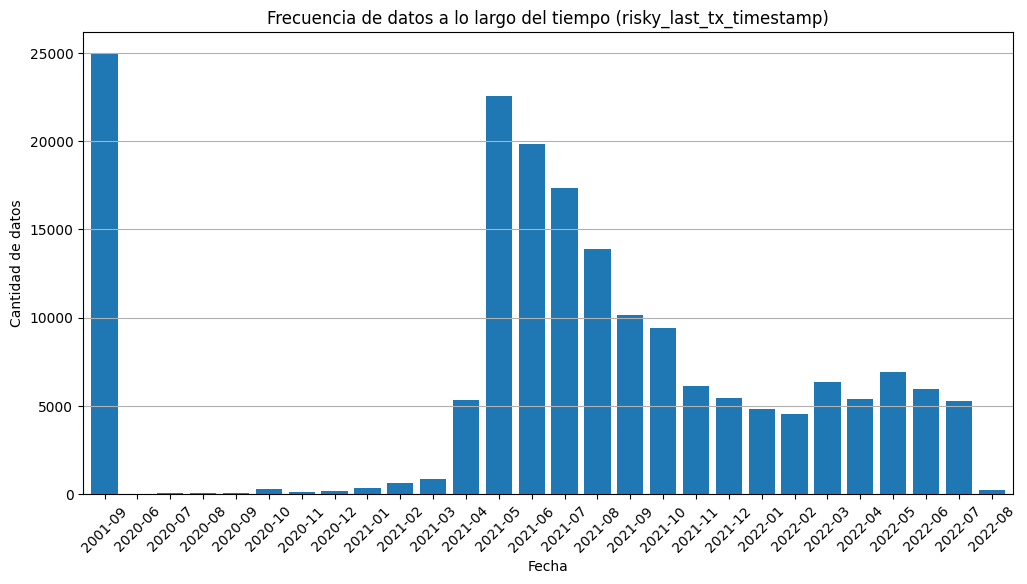

In [12]:
datetime_cols = df_eda.select_dtypes(include=['datetime']).columns.tolist()

for col in datetime_cols:
    plt.figure(figsize=(12, 6))
    df_eda[col].dt.to_period('M').value_counts().sort_index().plot(kind='bar', width=0.8)
    plt.title(f"Frecuencia de datos a lo largo del tiempo ({col})")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad de datos")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

Principales insights del EDA: 
 * Hay variables que son estilo ID, que no aportan a la información general y pueden generar sesgo.
 * 5 variables están en formato DateTime que pueden aportar información. 
 * Existen pares de variables altamente correlacionadas. 
 * Hay que tratar los outliers, ya que pueden afectar en el rendimiento del modelo. 
 * Las variables de fechas asociadas al riesgo tienen datos malos. 

## 2.2 Preprocesamiento de datos

Desiciones tomadas para el preprocesamiento: 

* `Hold-out`: 70% entrenamiento, 30% test

* `DropColumns`: Clase definida en utils.py que perimte eliminar las variables que generan sesgo: `borrow_block_number` y `wallet_address`
* `ReplaceOutliersWithMedian`: Clase definida en utils.py que permite reemplazar los outliers por la mediana de esa variable. En este caso se utilizó la mediana porque, para la mayoría de las variables, es más representativa que el promedio o lam moda, dado que estos últimos indicadores pueden estar afectado por la dispersión de los datos o la repetición de datos outliers. 
* `DropHighlyCorrelated`: Clase definida en utils.py que elimina una variable que tenga este fuera del rango permitido de correlación con otra, en este caso es de -0.9 a 0.9. Sin conocimiento expero se asume que se puede eliminar cualquier variable con el fin de que el modelo tenga menos variables redundantes de entrada y que su aprendizaje sea más eficiente. Para poder cumplir con todas las variables necesarias para todo el pipeline, se excluye de este análisis las variables de fecha, que tienen su procesamiento en el siguiente punto.  
* `process_timestamps`: Función definida en utils.py que permite transformar las variables fecha a datetime y extraerlas como nuevas variables month y year, además elimina a la variable original. Es decir para borrow_timestamp genera borrow_year, borrow_month y elimina borrow_timestamp. Además, elimina las variables de fecha asociadas al riesgo por lo visto en el EDA. 
* `identity_transform`: Permite que estandarizar el df de entrada. 
* `define_columns`: Función definida en utils.py que permite seleccionar las variables númerica y categóricas despues de haber realizado la primera parte del preprocesamiento, con esto se pueden escalar los datos dependiendo de su formato. 
* `MinMaxScaler`: Por simplicidad, se aplica este estandarizador a las variables númericas. En caso de hacer un trabajo aún más detallado se aplicaría una estandarización a cada variable dependiendo de su distribución. 
* `OneHotEncoder`: Para las variables categóricas, que en este caso son los meses y los años, variables previamente definidas. 


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df,  
    Y,
    test_size=0.3,
    random_state=42
)

drop_high_corr = utils.DropHighlyCorrelated(threshold=0.9, exclude_columns=["borrow_timestamp", "first_tx_timestamp", "last_tx_timestamp", "risky_first_tx_timestamp", "risky_last_tx_timestamp"])
replace_outliers = utils.ReplaceOutliersWithMedian(method="IQR", factor=1.5)

pipeline = Pipeline(steps=[
    ("drop_columns", utils.DropColumns(columns_to_drop=["borrow_block_number", "wallet_address"])),
    
    ("replace_outliers", replace_outliers),
    
    ("drop_high_corr_columns", drop_high_corr),
    
    ("process_timestamps", FunctionTransformer(utils.process_timestamps, validate=False)),
    
    ("dynamic_preprocessor", FunctionTransformer(utils.identity_transform))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)


print(f"Tamaño de X_train_transformed: {X_train_transformed.shape}")
print(f"Tamaño de y_train_filtered: {y_train.shape}")
print(f"Tamaño de X_test_transformed: {X_test_transformed.shape}")
print(f"Tamaño de y_test_filtered: {y_test.shape}")

numeric_features, categorical_features = utils.define_columns(pd.DataFrame(X_train_transformed))

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

complete_pipeline = Pipeline(steps=[
    ("initial_steps", pipeline),  
    ("preprocessor", preprocessor)  
])

X_train_final = complete_pipeline.fit_transform(X_train)
X_test_final = complete_pipeline.transform(X_test)

Tamaño de X_train_transformed: (124028, 65)
Tamaño de y_train_filtered: (124028, 1)
Tamaño de X_test_transformed: (53156, 65)
Tamaño de y_test_filtered: (53156, 1)


Este sería el array de entrada, que aquí se puede ver en formato DataFrame:

In [14]:
df_transformed = pd.DataFrame(X_train_final)
print(df_transformed.shape)
df_transformed.head()

(124028, 104)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103
0,0.202718,0.020101,0.034403,0.591603,0.018276,0.249438,0.007143,0.032258,2.690463e-07,0.000540,0.003501,0.039361,0.007388,0.000438,0.002628,3.089762e-01,3.764066e-03,0.001272,0.268184,0.287561,0.003029,0.006061,0.554373,0.000348,0.011763,0.010753,0.000000,0.000000,0.00,0.002009,0.029126,3.896751e-04,0.010733,0.000000,0.0,0.0,0.0,0.0,0.056693,0.088076,0.378612,0.873494,0.214286,0.470938,0.365402,0.381406,0.792595,0.222947,0.334723,0.645163,0.0,0.451373,0.412209,0.0,0.179755,0.158185,0.483528,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.129923,0.056712,0.060902,0.585878,0.133257,0.329508,0.000000,0.000000,0.000000e+00,0.000000,0.032812,0.088488,0.061291,0.049248,0.045355,6.326634e-07,0.000000e+00,0.000000,0.264496,0.286769,0.000000,0.000000,0.000000,0.022759,0.071114,0.408602,0.008914,0.045098,0.76,0.000000,0.368932,2.788362e-02,0.049677,0.009180,0.0,0.0,0.0,0.0,0.123826,0.171948,0.513907,0.873494,0.214286,0.512327,0.282999,0.393953,0.913140,0.167767,0.179750,0.266067,0.0,0.329669,0.624666,0.0,0.193117,0.195325,0.327591,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.346950,0.031587,0.029289,0.617366,0.011988,0.189586,0.010714,0.048387,5.719849e-02,0.000004,0.045055,0.421519,0.531290,0.039966,0.045355,6.326634e-07,1.828790e-01,0.000000,0.573551,0.286769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.019417,2.106273e-02,0.640539,0.003791,0.0,0.0,0.0,0.0,0.320589,0.138752,0.721121,0.873494,0.785714,0.549902,0.375096,0.489353,0.990515,0.041811,0.001209,0.452046,0.0,0.597265,0.736047,0.0,0.182837,0.298676,0.441904,0.0,0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.205416,0.014358,0.024640,0.604008,0.008052,0.151366,0.000000,0.000000,0.000000e+00,0.000000,0.000072,0.001160,0.000497,0.003836,0.005981,6.326634e-07,8.373655e-07,0.000000,0.264497,0.286769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.009709,1.260845e-07,0.000007,0.000000,0.0,0.0,0.0,0.0,0.743884,0.529830,0.278740,0.222892,0.214286,0.461133,0.324803,0.228863,0.908704,0.749499,0.573639,0.440133,0.0,0.164976,0.307324,0.0,0.397205,0.063048,0.244356,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.319614,0.030151,0.051604,0.569656,0.067103,0.602313,0.000000,0.000000,0.000000e+00,0.000000,0.011373,0.095273,0.000917,0.008464,0.011671,5.876060e-01,6.143445e-01,0.758962,0.348297,0.520497,0.038607,0.000000,0.662278,0.022759,0.071114,0.376344,0.008914,0.045098,0.58,0.174446,0.388350,3.890932e-02,0.028552,0.000378,0.0,0.0,0.0,0.0,0.618750,0.854939,0.497657,0.042169,0.142857,0.203523,0.596691,0.435029,0.824908,0.113219,0.811741,0.918863,0.0,0.506433,0.412893,0.0,0.683097,0.110084,0.554658,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 3. Modelamiento

## 3.1 Baseline

Utilizando el `hold-out` previamente realizado, se aplica el pipeline completo consierando un modelo de base, definiendo solo su máxima profundidad, a continuación se utiliza `classification_report` y también se estima el `AUC-PR` métrica importante para las evaluaciones en el proyecto.

In [15]:
complete_pipeline_with_model = Pipeline(steps=[
    ("initial_steps", pipeline),  
    ("preprocessor", preprocessor),  
    ("model", DecisionTreeClassifier(random_state=10, max_depth=5)) 
])

complete_pipeline_with_model.fit(X_train, y_train)

y_pred = complete_pipeline_with_model.predict(X_test)
y_pred_proba = complete_pipeline_with_model.predict_proba(X_test)[:, 1]  

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)

print(f"AUC-PR: {auc_pr:.4f}")

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     32790
           1       0.79      0.63      0.70     20366

    accuracy                           0.79     53156
   macro avg       0.79      0.76      0.77     53156
weighted avg       0.79      0.79      0.79     53156

AUC-PR: 0.8125


Decisiones de Diseño: 

Se seleccionó un árbol de decisión debido a su interpretabilidad y facilidad de configuración. La restricción a una profundidad de 5 asegura que el modelo se mantenga simple y evita el sobreajuste.

Para evaluarlo se utilizó `classification_report` para obtener las principales métricas y el área bajo la curva de precisión-recall (AUC-PR) como métrica adicional.

Este es el modelo baseline que entrega un punto de partida para evaluar y comparar modelos más complejos.

## 3.2 Modelos de Machine Learning

### 3.2.1 XGboost

El primer modelo a desarrollar es el clasificador de XGBoost. Se seleccionó este modelo por tratar de uno de los más avanzados, considerando su eficiencia, posibilidad de ajustar más hiperparámetros y el poder integrarlo más simple para entrenar con cpu. Los hiperparámetros definidos en esta manera inicial son:

- max_depth = 6: Limita la profundidad de los árboles para controlar el sobreajuste.

- learning_rate = 0.1: Controla la contribución de cada árbol al modelo final.

- n_estimators = 100: Determina el número de árboles a entrenar.

- subsample = 0.8: Proporción de datos utilizados para construir cada árbol.

- colsample_bytree = 0.8: Proporción de columnas seleccionadas aleatoriamente para cada árbol.

- gamma = 1: Regularización para reducir el sobreajuste.

- eval_metric = "logloss": Métrica de evaluación utilizada durante el entrenamiento. Utilizar logloss trata de mejor manera los datos con desbalance. Por más que nuestros datos no presentan un desbalance crítico, si ayuda al desempeño disminuir esa brecha.

In [16]:
pipeline_xgb = Pipeline(steps=[
    ("initial_steps", pipeline),  
    ("preprocessor", preprocessor),  
    ("model", XGBClassifier(
        random_state=42,
        max_depth=6,
        learning_rate=0.1, 
        n_estimators=100,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        gamma=1,  
        eval_metric="logloss"
    ))  
])

pipeline_xgb.fit(X_train, y_train)

y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

print("Reporte de clasificación (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
auc_pr_xgb = auc(recall_xgb, precision_xgb)
print(f"AUC-PR (XGBoost): {auc_pr_xgb:.4f}")


Reporte de clasificación (XGBoost):
              precision    recall  f1-score   support

           0       0.83      0.93      0.87     32790
           1       0.85      0.69      0.76     20366

    accuracy                           0.84     53156
   macro avg       0.84      0.81      0.82     53156
weighted avg       0.84      0.84      0.83     53156

AUC-PR (XGBoost): 0.8785


### 3.2.2 LightGBM

Otro de los modelos más avanzados, que permite controlar mejor el desbalance. Este modelo también permite ajustar distintos hiperparámetros, por lo que permite más flexibilidad. Los hiperparámetros definidos en esta manera inicial son:

- max_depth = 6: Controla la profundidad de los árboles, ayudando a prevenir el sobreajuste.
- learning_rate = 0.1: Determina la tasa de aprendizaje para ajustar el impacto de cada árbol en el modelo.
- n_estimators = 100: Especifica el número total de árboles que se construirán.
- num_leaves = 31: Número máximo de hojas por árbol; controla la complejidad del modelo.
- subsample = 0.8: Proporción de muestras utilizadas para construir cada árbol, contribuyendo a reducir el sobreajuste.
- colsample_bytree = 0.8: Proporción de características consideradas al dividir cada nodo.
- min_child_weight = 1: Mínima suma de pesos necesarios en un nodo hoja, lo que controla la regularización.
- reg_alpha = 0.1: Término de regularización L1 para evitar el sobreajuste.
- reg_lambda = 0.1: Término de regularización L2 que penaliza las grandes magnitudes de los parámetros.

In [17]:
pipeline_lgbm = Pipeline(steps=[
    ("initial_steps", pipeline),  
    ("preprocessor", preprocessor), 
    ("model", LGBMClassifier(
        random_state=42,
        max_depth=6,  
        learning_rate=0.1,  
        n_estimators=100,  
        num_leaves=31,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        min_child_weight=1,  
        reg_alpha=0.1,  
        reg_lambda=0.1  
    ))  
])

pipeline_lgbm.fit(X_train, y_train)

y_pred_lgbm = pipeline_lgbm.predict(X_test)
y_pred_proba_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]

print("Reporte de clasificación (LightGBM):")
print(classification_report(y_test, y_pred_lgbm))

precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
auc_pr_lgbm = auc(recall_lgbm, precision_lgbm)
print(f"AUC-PR (LightGBM): {auc_pr_lgbm:.4f}")

/Users/tomasreyes/Desktop/Cosas U /Laboratorio de Programación Científica/MDS7202-1/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tomasreyes/Desktop/Cosas U /Laboratorio de Programación Científica/MDS7202-1/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 47943, number of negative: 76085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11718
[LightGBM] [Info] Number of data points in the train set: 124028, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386550 -> initscore=-0.461838
[LightGBM] [Info] Start training from score -0.461838
Reporte de clasificación (LightGBM):
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     32790
           1       0.85      0.68      0.75     20366

    accuracy                           0.83     53156
   macro avg       0.83      0.80      0.81     53156
weighted avg       0.83      0.83      0.83     53156

AUC-PR (LightGBM): 0.8715


### 3.3.3 Random Forest

Randon Forest es una combinación de distintos árboles de desición, donde usando bagging permite obtener mejores resultados. Los hiperparámetros definidos en esta manera inicial son:

- max_depth = 10: Restringe la profundidad máxima de los árboles para evitar el sobreajuste.
- n_estimators = 200: Número de árboles que conforman el bosque.
- max_features = "sqrt": Número máximo de características consideradas al dividir un nodo.
- min_samples_split = 10: Número mínimo de muestras requeridas para dividir un nodo interno.
- min_samples_leaf = 5: Mínimo número de muestras necesarias en un nodo hoja.
- bootstrap = True: Activa el uso de muestras de bootstrap para construir los árboles.
- class_weight = "balanced": Ajusta automáticamente los pesos de las clases para manejar datos desbalanceados.

A diferencia de los modelos anteriores, Random Forest usa bagging en vez de boosting. Los otros modelos son más fuertes en el manejo de desbalance, pero con el hiperparámetro `class_weight = "balanced"` puede obtener mejores resultados en estos casos.

In [18]:
pipeline_rf = Pipeline(steps=[
    ("initial_steps", pipeline), 
    ("preprocessor", preprocessor), 
    ("model", RandomForestClassifier(
        random_state=42,
        max_depth=10,  
        n_estimators=200,  
        max_features="sqrt",
        min_samples_split=10,  
        min_samples_leaf=5,  
        bootstrap=True,  
        class_weight="balanced"  
    ))  
])

pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print("Reporte de clasificación (Random Forest):")
print(classification_report(y_test, y_pred_rf))

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
auc_pr_rf = auc(recall_rf, precision_rf)
print(f"AUC-PR (Random Forest): {auc_pr_rf:.4f}")

/Users/tomasreyes/Desktop/Cosas U /Laboratorio de Programación Científica/MDS7202-1/.venv/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Reporte de clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.88      0.86     32790
           1       0.79      0.72      0.75     20366

    accuracy                           0.82     53156
   macro avg       0.81      0.80      0.80     53156
weighted avg       0.82      0.82      0.82     53156

AUC-PR (Random Forest): 0.8655


Se deben responder las siguientes preguntas:  
1. ¿Algún clasificador supera al modelo baseline?  
2. ¿Cuál es el mejor clasificador entrenado y por qué?  
3. ¿Qué factores explican la superioridad del mejor clasificador?  
4. ¿Qué modelo es más eficiente para realizar optimizaciones en términos de tiempo de entrenamiento?  


Se puede observar que en los 3 casos se supera el rendimiento del modelo baseline, que era lo que se esperaba considerando que el modelo base es simple, no tiene mayor complejizidad ni específicidad de sus hiperparámetros y entrega resultados bien rudimentarios. 

Ahora comparando entre los 3 modelos seleccionados, el mejor de los 3 es XGBoost. Esto porque tiene mejores resultados en todas las métricas, es decir, se adapta mejor al caso del desbalance y en la métrica de AUC-PR que está diseñada para interpretar mejor estos casos, también es mejor.

El desempeño de XGBoost por sobre los otros modelos se puede entender desde su manejo de casos de desbalance, aplicación de hiperparámetros más específicos y el uso de `LogLoss` como métrica de desempeño. Aún así, cabe el caso de que la selección de los hiperparámetros afecte en el desempeño, por lo que la optimización de este modelo inicial entregará una respuesta más completa.

El modelo a usar en adelante es el XGBoost.

## 3.3 Optimización de modelos. Tracking con MLFlow

Con el modelo definido, se deciden optimizar sus hiperparámetros utilizando `Optuna`. Para realizar la optimización, se decide optimizar la métrica AUC_PR, primero, porque permite obtener una buena medición en datos desbalanceados ya que hace énfasis en la capacidad de distinguir los distintos casos, no en los resultados exactos como tal. Y segundo, porque es la métrica de la competencia. 

Esta etapa del proyecto se le destinó harto tiempo por su importancia al momento de obtener un buen modelo con resultados replicables pero no overfitting. Si se invirtiera más tiempo se podría hacer énfasis en más detalles, probrar más casos de hiperparámetros, o hacer más pruebas con distintas variaciones, como variando en el pipeline.

Viendo el resultado de aplicar la optimización, el hiperparámetro con mayor impacto fue `max_depth`, considerando que es el hiperparámetro que controla la profundidad de los árboles tiene sentido. 

In [19]:
mlflow.set_tracking_uri("file:../mlruns")
experiment_name = "XGBoost_Optimization_Notebook"
mlflow.set_experiment(experiment_name)

def get_best_model(experiment_id):
    runs = mlflow.search_runs(experiment_id)
    best_model_id = runs.sort_values("metrics.auc_pr", ascending=False)["run_id"].iloc[0]
    best_model = mlflow.sklearn.load_model("runs:/" + best_model_id + "/model")
    return best_model

def optimize_model(n_trials=50, n_jobs=4):
    experiment_name = f"XGBoost_Optimization_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}_param_importance"
    mlflow.set_experiment(experiment_name)

    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        }
        model = XGBClassifier(**params, eval_metric="logloss", random_state=42, n_jobs=n_jobs)
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)
        y_pred_proba = model.predict_proba(X_test_final)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        auc_pr = auc(recall, precision)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report["weighted avg"]["f1-score"]
        precision_score = report["weighted avg"]["precision"]
        recall_score = report["weighted avg"]["recall"]

        with mlflow.start_run(run_name=f"Trial_{trial.number}"):
            mlflow.set_tag("model_type", "XGBoost")
            mlflow.set_tag("pipeline_step", "Optimization")
            mlflow.log_params(params)
            mlflow.log_metric("auc_pr", auc_pr)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("precision", precision_score)
            mlflow.log_metric("recall", recall_score)
            signature = infer_signature(X_train_final, model.predict(X_train_final))
            mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)
        return auc_pr

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    # Obtener la importancia de los hiperparámetros
    importance = get_param_importances(study)
    print("Importancia de los hiperparámetros:")
    for param, value in importance.items():
        print(f"{param}: {value:.4f}")

    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    best_model = get_best_model(experiment_id)
    return best_model

best_model = optimize_model(n_trials=100, n_jobs=8)

2024/12/12 23:03:42 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_Optimization_2024-12-12_23-03-42_param_importance' does not exist. Creating a new experiment.
[I 2024-12-12 23:03:42,579] A new study created in memory with name: no-name-9251d530-5174-4486-a02c-0890ef61124c
[I 2024-12-12 23:03:53,483] Trial 0 finished with value: 0.8380850530479649 and parameters: {'max_depth': 3, 'learning_rate': 0.04585582146823577, 'n_estimators': 144, 'subsample': 0.7328209060304545, 'colsample_bytree': 0.555452611818861, 'gamma': 4.0294922323843245, 'reg_alpha': 0.5418522665045244, 'reg_lambda': 0.4479828271685764}. Best is trial 0 with value: 0.8380850530479649.
[I 2024-12-12 23:03:56,141] Trial 1 finished with value: 0.9036476449620927 and parameters: {'max_depth': 6, 'learning_rate': 0.2541608076731263, 'n_estimators': 214, 'subsample': 0.8324722182757529, 'colsample_bytree': 0.5994712524763492, 'gamma': 3.093194889970218, 'reg_alpha': 0.5653638617009719, 'reg_lambda': 0.37824032201

Importancia de los hiperparámetros:
max_depth: 0.7217
learning_rate: 0.1912
gamma: 0.0274
n_estimators: 0.0258
subsample: 0.0118
reg_alpha: 0.0077
colsample_bytree: 0.0075
reg_lambda: 0.0070


La implementación de MLflow permite hacer el seguimiento de todo lo que ocurre al entrenar al modelo. A continuación se adjuntan imagenes del proceso utilizando la interfaz de MLFlow: 

![Uso de la interfaz de MLFlow](../imgs/mlflow1.png)

![Uso de la interfaz de MLFlow](../imgs/mlflow2.png)

El modelo que tuvo mejor resultado tiene esta feature importance, en interpretabilidad se detalla más el impacto de esa variable en específico: 

![Uso de la interfaz de MLFlow](../plots/feature_importance_trial_98.png)

### 3.3.1 Mejor modelo pipeline

Con la mejor combinación de hiperparámetros se desarrolla el pipeline que definirá la predicción que irá a la competencia.

In [20]:
pipeline_xgb = Pipeline(steps=[
    ("initial_steps", pipeline), 
    ("preprocessor", preprocessor),  
    ("model", XGBClassifier(
        random_state=42,
        max_depth=10,  
        learning_rate=0.1085322780702538, 
        n_estimators=288,  
        subsample=0.8603107864174767,  
        colsample_bytree=0.8554986476750236,  
        gamma=0.2872010431722567,  
        reg_alpha=0.5617612273772564, 
        reg_lambda=0.036858705541494285,  
        eval_metric="logloss"
    ))  
])

pipeline_xgb.fit(X_train, y_train)

y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

print("Reporte de clasificación (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
auc_pr_xgb = auc(recall_xgb, precision_xgb)
print(f"AUC-PR (XGBoost): {auc_pr_xgb:.4f}")

auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"AUC-ROC (XGBoost): {auc_roc_xgb:.4f}")

Reporte de clasificación (XGBoost):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     32790
           1       0.90      0.79      0.84     20366

    accuracy                           0.89     53156
   macro avg       0.89      0.87      0.88     53156
weighted avg       0.89      0.89      0.89     53156

AUC-PR (XGBoost): 0.9356
AUC-ROC (XGBoost): 0.9514


En utils.py se define la función generateFiles que permite obtener las predicciones para la competencia

In [21]:
utils.generateFiles(predict_data_3, pipeline_xgb)

## 3.4 Interpretabilidad

In [22]:
if hasattr(preprocessor, "get_feature_names_out"):
    feature_names = preprocessor.get_feature_names_out()
else:
    numeric_features, categorical_features = utils.define_columns(pd.DataFrame(X_train))
    ohe_categories = preprocessor.named_transformers_["cat"].categories_
    one_hot_feature_names = [
        f"{cat}_{val}"
        for cat, categories in zip(categorical_features, ohe_categories)
        for val in categories
    ]
    feature_names = numeric_features + one_hot_feature_names

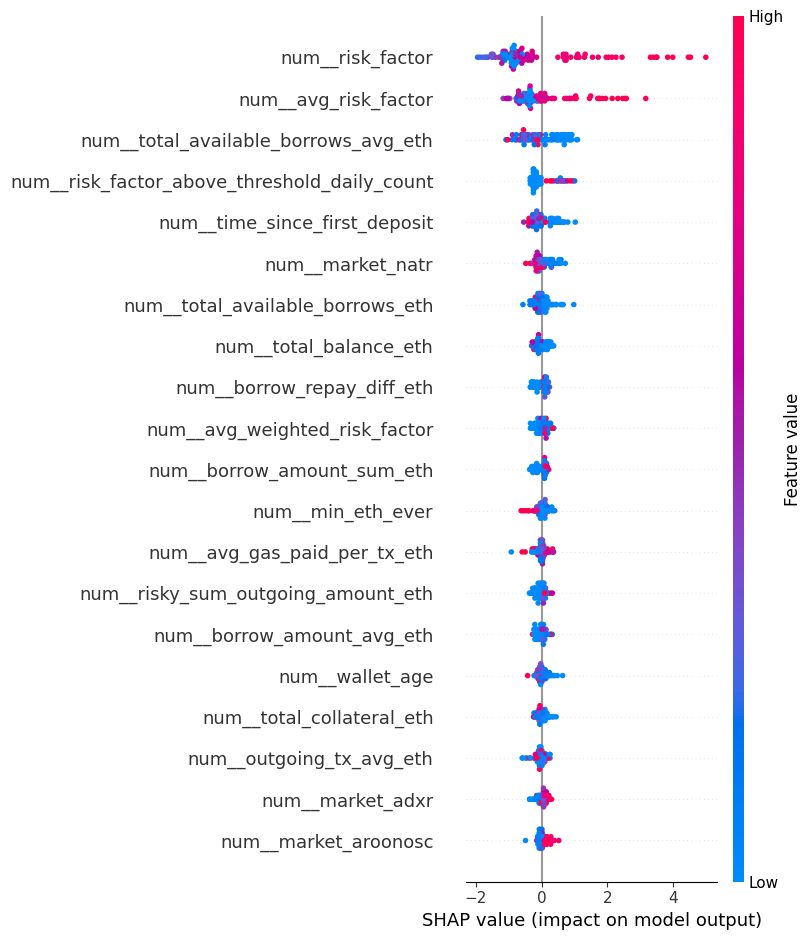

In [ ]:
explainer = shap.Explainer(pipeline_xgb.named_steps['model'], X_train_final)

shap_values = explainer(X_test_final[:100])
shap.summary_plot(shap_values, features=X_test_final[:100], feature_names=feature_names)

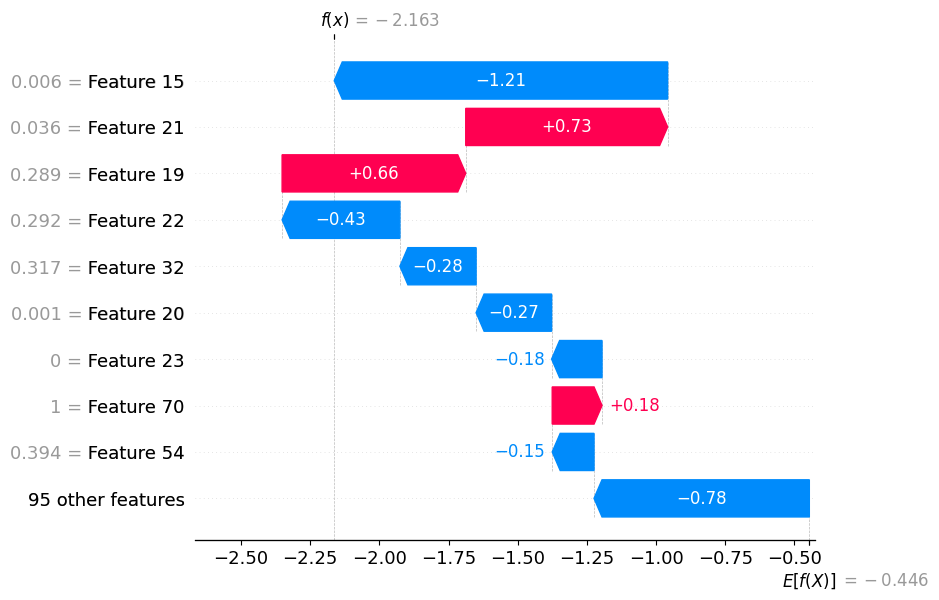

In [24]:
shap.waterfall_plot(shap_values[0])

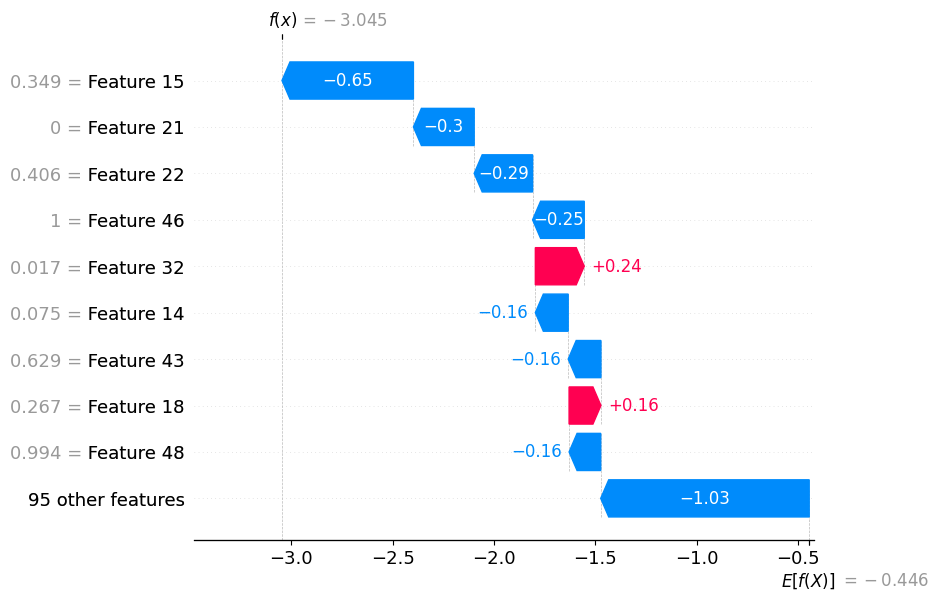

In [25]:
shap.waterfall_plot(shap_values[1])

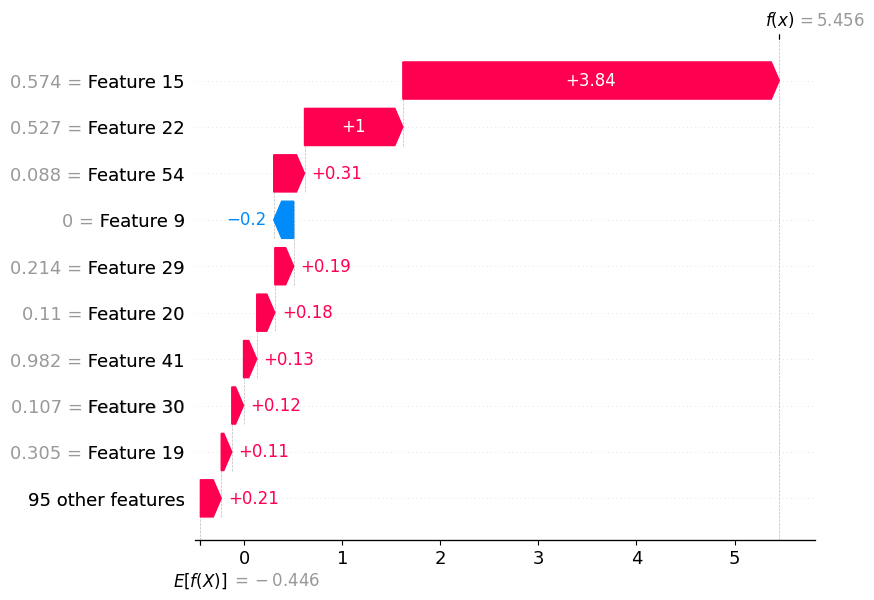

In [26]:
shap.waterfall_plot(shap_values[2])

Se puede ver en las distintas figuras que el atributo que más impacta en las predicciones es el feature 15 que es el `risk_factor`. Y hace todo el sentido, porque corresponde al factor de riesgo calculado para la billetera, es decir, si es mayor tiene más probabilidades de ser moroso. Esto se puede ejemplificar para los 3 casos detallados, en que si aumenta el `risk_factor`es más probable que el cliente sea moroso y al revés, si el `risk_factor` es menor, disminuye sus probabilidades de ser un caso moroso.

Para detallar sesgo se tendría que conocer como se calcula ese factor y entender a quienes se les asigna, dado que el segundo atributo con mayor impacto es `avg_ris_factor` que es un derivado del atributo anterior.

# 4. MLOps

## 4.2 Desarrollo de Aplicación Web

El desarrollo de una aplicación web permite tener una interfaz amigable que permita interactuar con el modelo trabajado. De modo que le permita al usuario generar predicciones a partir de una introducción manual de los datos o de utilizar un archivo .csv. Además, es necesario dockerizar el proyecto para otorgar escabilidad y despliguete eficientes. 

Como ya está guardado el mejor modelo, se guarda el pipeline, de modo que los datos ingresados tengan la transformación que corresponde para poder ejecutar la predicción.

In [28]:
pipeline_path = "../backend/models/complete_pipeline.pkl"
joblib.dump(complete_pipeline, pipeline_path)

['../backend/models/complete_pipeline.pkl']

Para desarrollar la aplicación web, se definen 2 directorios: Backend y Frontend. Donde el backend es donde se ejecuta la lógica del modelo, es decir, la aplicación del pipeline y las predicciones. El frontend es donde se usa una interfaz amigable para el usuario y que debe hacer las solicitudes al backend para obtener las respuestas. 

El backend es desarrollado con FastApi, donde está el archivo principal que es app.py, que ahí es donde se carga el modelo y el pipeline, se define el formato de los datos de ingreso (para que se puedan desarrollar las transformaciones) y se generan 2 endpoints: predict-manual y predict-file. En el primero se ingresan los datos a mano, donde se llena un diccionario y a partir de esto se obtiene la predicción. Y en el segundo se inserta un .csv con los datos y me entrega la predicción. 

El backend también cuenta con la carpeta models, que es donde está el modelo y el pipeline, también está el archivo utils.py que permite utilizar todas las funciones aplicada en el pipeline, y está el Dockerfile que define la construcción de la imagen de Docker para el backend. 

La construcción de la imagen de Docker consta de: 
- Configurar Python
- Instalar las dependencias definidas en el requirements.txt específico del backend
- Utilizar los archivos descritos: app, model, pipeline y utils
- Definir el puerto en el que es accesible el backend, en este caso, es el 8000
- Establecer que el servidor se levanta con Uvicorn. 

![Uso de la interfaz de MLFlow](../imgs/backend.png)

El frontend es la interfaz con la que iteractúa el usuario, que es más intuitiva que utilizar el backend. En la carpeta frontend está el archivo frontend.py que define la interfaz gráfica usando Gradio. En particular tiene las pestañas para hacer la predicción manual o desde un archivo .csv. 

En este caso del Dockerfile define la construcción que va de la forma: 
- Establecer Python 
- Instalar las dependencias propias requirements.txt propias del frontend
- Toma el archivo frontend.py 
- Configura que Gradio utilice el puerto 7860. 

![Uso de la interfaz de MLFlow](../imgs/frontend.png)

Con esto en consideración, es ejecuta la dockerización que permite ejecutar tanto backend como frontend en componentes separados, facilitando el despliegue. La estructura se basa en el archivo docker-compose.yml que conecta el trabajo del backend con el frontend. Su mayor uso es conectar las llamadas del frontend con el backend configurando que esto se realiza en el puerto 8000, que es donde está definido el levantamiento del backend.

![Uso de la interfaz de MLFlow](../imgs/docker.png)

## 4.3 Monitoreo

## 4.5 Canalización productivas

# 5. Resultados

El rendimiento del modelo evolucionó de manera significativa a lo largo de las iteraciones. En la primera etapa, con un enfoque básico que incluyó eliminación de variables altamente correlacionadas y la estandarización con MinMaxScaler y OneHotEncoder, el modelo XGBoost logró un AUC-PR de 0.79. Este resultado reflejaba un desempeño inicial prometedor, pero indicaba que había oportunidades para mejorar el preprocesamiento y optimización.

En la segunda iteración, con la incorporación del tratamiento de outliers y un análisis más detallado de los datos, además de pruebas con diferentes escaladores, el modelo alcanzó un AUC-PR de 0.85. Este avance mostró el impacto positivo de refinar las etapas iniciales del pipeline y optimizar los hiperparámetros utilizando Optuna junto con MLFlow.

Finalmente, en la tercera etapa, el foco cambió hacia la robustez del modelo y la implementación de MLOps, priorizando la escalabilidad y replicabilidad. Aunque el AUC-PR disminuyó a 0.73 en esta iteración, esto se debió a que no se optimizó más el modelo, sino que se consolidaron herramientas como Docker, FastAPI y Gradio para integrar el modelo en un sistema funcional.

En un contexto bancario, estos resultados permiten al banco evaluar la probabilidad de que un cliente se convierta en moroso con base en sus transacciones y características relacionadas. Esto es especialmente valioso para mejorar la gestión de riesgos y priorizar recursos. Por ejemplo, un AUC-PR de 0.85 implica que el modelo puede identificar con alta precisión a los clientes con mayor riesgo, reduciendo tanto las pérdidas financieras como los costos operativos asociados con la morosidad.

Además, el uso de características como el risk_factor, identificado como la variable más importante, permite a los analistas del banco interpretar los resultados de manera lógica y tomar decisiones más informadas. Por otro lado, la robustez del modelo y su integración parcial en un pipeline MLOps proporcionan una base para que el sistema sea utilizado a gran escala con clientes reales, incluso si algunas herramientas como AirFlow no se implementaron completamente.

Los resultados mejoraron considerablemente entre la primera y la segunda iteración debido a un enfoque más detallado en el preprocesamiento y la optimización. Mientras que en la primera iteración el modelo dependía de un pipeline básico y entregaba resultados decentes, en la segunda etapa se lograron identificar y tratar outliers, ajustar escaladores y aprovechar Optuna para optimizar hiperparámetros clave, lo que impulsó significativamente el rendimiento. La inclusión de métricas adicionales como F1-score, precisión y recall permitió validar que el modelo no solo tenía buenas métricas generales, sino que también era funcional en un contexto práctico. En la tercera etapa, la métrica disminuyó, pero el enfoque en la implementación de MLOps garantizó un modelo más robusto y replicable, aunque esto no afectó directamente el rendimiento métrico.

El parámetro max_depth del modelo XGBoost fue uno de los más relevantes, ya que impacta directamente en el tamaño de los árboles y, por ende, en la capacidad del modelo para ajustarse a los datos. Un max_depth demasiado alto llevó a riesgos de overfitting al capturar ruido en los datos, mientras que configuraciones más moderadas permitieron un mejor equilibrio. Otros hiperparámetros importantes fueron learning_rate y subsample, que ayudaron a controlar la velocidad de aprendizaje y la cantidad de datos utilizados en cada iteración, respectivamente.

El uso de AUC-PR como métrica principal también fue una decisión clave para abordar el desbalance en los datos, asegurando que el modelo priorizara correctamente los casos positivos (clientes morosos). Además, los tratamientos de outliers influyeron significativamente, ya que eliminarlos agresivamente llevó a casos de overfitting que fueron mitigados con validación cruzada.

El overfitting surgió principalmente al ajustar en exceso los hiperparámetros o al eliminar de forma agresiva los outliers, ya que el modelo podía aprender patrones específicos de los datos de entrenamiento que no se generalizaban bien. Para mitigarlo, se utilizó validación cruzada y técnicas de regularización inherentes al modelo XGBoost, como reg_alpha y reg_lambda. Por otro lado, el underfitting fue menos frecuente, pero se evitó asegurando una optimización iterativa con Optuna y manteniendo suficientes datos relevantes para el entrenamiento.

La elección final de XGBoost como modelo principal fue justificada por su capacidad para superar consistentemente al modelo baseline, así como a otros modelos probados como Random Forest y LightGBM. Aunque estos últimos también mostraron buen rendimiento, XGBoost demostró ser más robusto en términos de métricas y eficiencia.

# 6. Conclusiones

A lo largo de las iteraciones del proyecto, el modelo que consistentemente mostró mejor desempeño fue XGBoost. Este modelo superó tanto a los modelos baseline como a otras alternativas como Random Forest y LightGBM en todas las etapas. En particular, durante la segunda iteración, XGBoost alcanzó su mejor desempeño con un AUC-PR de 0.85, gracias a un pipeline mejorado de preprocesamiento, la eliminación de outliers, y la optimización exhaustiva de hiperparámetros utilizando Optuna. Este resultado refleja la capacidad del modelo para manejar datos complejos y desbalanceados, identificando de manera efectiva a los clientes con mayor riesgo de morosidad.

El proyecto trabajó con datos relacionados con préstamos de distintas billeteras, lo que presentó desafíos típicos de este tipo de datos, como alta dimensionalidad, presencia de outliers, y desbalance en las clases. Durante el análisis, se identificó que la variable risk_factor era la más importante para predecir la morosidad, lo que era lógico dado el contexto del problema.

La eliminación de columnas con alta correlación y variables de ID fue clave para evitar problemas de redundancia y sesgos. Asimismo, la decisión de utilizar AUC-PR como métrica principal fue fundamental para abordar el desbalance en los datos y garantizar que el modelo priorizara correctamente los casos más relevantes. Estas observaciones ayudaron a simplificar el conjunto de datos sin sacrificar información relevante, lo que mejoró tanto la interpretabilidad como el rendimiento del modelo.

Las herramientas y técnicas utilizadas desempeñaron un papel crucial en el éxito del proyecto. La creación de un pipeline de preprocesamiento permitió estructurar de manera eficiente los pasos necesarios para limpiar y transformar los datos, asegurando consistencia en todas las etapas. La optimización de hiperparámetros con Optuna fue especialmente útil para maximizar el rendimiento del modelo, mientras que MLFlow facilitó el seguimiento y comparación de diferentes experimentos.

En cuanto al tratamiento de outliers, el reemplazo por la mediana demostró ser una estrategia efectiva para preservar la estabilidad del modelo sin introducir ruido adicional. Sin embargo, esta técnica debe aplicarse con precaución para evitar la pérdida de patrones importantes en los datos.

Por otro lado, las herramientas de MLOps, como Docker, FastAPI y Gradio, facilitaron la integración del modelo en un entorno funcional, aunque el uso de AirFlow no se completó. 

Las decisiones clave tomadas a lo largo del proyecto fueron fundamentales para alcanzar los resultados obtenidos. La eliminación de columnas con alta correlación permitió reducir la dimensionalidad del conjunto de datos y mejorar tanto la eficiencia como la interpretabilidad del modelo. De manera similar, la exclusión de variables de ID ayudó a prevenir posibles sesgos y a evitar que el modelo aprendiera patrones irrelevantes. El tratamiento de outliers mediante su reemplazo por la mediana contribuyó a manejar valores extremos sin comprometer la estabilidad del modelo. La elección de XGBoost como modelo principal, junto con su optimización mediante Optuna, fue una de las decisiones más impactantes, ya que permitió obtener un rendimiento superior en comparación con otras alternativas como LightGBM y Random Forest. Finalmente, el esfuerzo por dockerizar el pipeline garantizó la reproducibilidad y escalabilidad del proyecto, consolidando una base sólida para futuras iteraciones. Estas decisiones reflejan un enfoque estratégico que balanceó la complejidad técnica con los objetivos prácticos del proyecto.

El proyecto logró desarrollar un modelo efectivo para predecir la morosidad en clientes bancarios, lo que ofrece un impacto práctico significativo al permitir una mejor gestión del riesgo crediticio. Las decisiones tomadas en cada etapa, desde el preprocesamiento hasta la implementación de herramientas de MLOps, reflejan un balance entre rigor técnico y pragmatismo.

Si bien algunas herramientas no pudieron integrarse completamente, el enfoque general garantizó que el modelo final fuera funcional, robusto y escalable. Este trabajo sienta las bases para futuras iteraciones que podrían incluir una mayor automatización en el flujo de trabajo y la integración completa de herramientas como AirFlow. En última instancia, el proyecto requiere una combinación de buenas prácticas de machine learning, optimización cuidadosa y herramientas modernas puede transformar datos complejos en soluciones concretas y aplicables.